In [1]:
import optuna
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from  sklearn.tree import DecisionTreeClassifier
from  sklearn.model_selection import train_test_split
import operator
import random

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
import riiideducation
import dask.dataframe as dd
import  pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import riiideducation

env = riiideducation.make_env()


In [2]:
data= pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
                nrows=10**7, dtype={'timestamp': 'int64', 'user_id': 'int32' ,
                                                  'content_id': 'int16','content_type_id': 'int8',
                                    'task_container_id':'int16','user_answer':'int8',
                                                  'answered_correctly':'int8',
                                                  'prior_question_elapsed_time': 'float32',
                                                  'prior_question_had_explanation': 'boolean'}
              )

In [3]:
print(data.shape)
data.head()

(10000000, 10)


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [4]:
## removing letures data
data = data[data['content_type_id']==0]
print(data.shape)

(9804604, 10)


In [5]:
## sort by timestamp 
data = data.sort_values(['user_id','timestamp'])
data.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [6]:
user_df = data[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum', 'count'])
user_df.columns = ['answered_correctly_user', 'sum_user', 'count_user']
user_df.head()

,answered_correctly_user,sum_user,count_user
user_id,,,
115,0.695652,32.0,46
124,0.233333,7.0,30
2746,0.578947,11.0,19
5382,0.672000,84.0,125
8623,0.642202,70.0,109


In [7]:
content_df = data[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean', 'sum', 'count'])
content_df.columns = ['answered_correctly_content', 'sum_content', 'count_content']
content_df.head()

,answered_correctly_content,sum_content,count_content
content_id,,,
0,0.908828,628.0,691
1,0.893939,649.0,726
2,0.562319,2531.0,4501
3,0.780316,1776.0,2276
4,0.627973,1980.0,3153


In [8]:
#reading in question df
questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv',
#                             usecols=[0, 3],
#                             dtype={'question_id': 'int16',
#                               'part': 'int8'}
                          )

In [9]:
questions_df

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


In [10]:
questions_df['part'].value_counts()

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

In [11]:
questions_df = questions_df.merge(content_df,
                                  left_on = 'question_id', right_on = 'content_id', how = 'left')
questions_df

,question_id,bundle_id,correct_answer,part,tags,answered_correctly_content,sum_content,count_content
0,0,0,0,1,51 131 162 38,0.908828,628.0,691.0
1,1,1,1,1,131 36 81,0.893939,649.0,726.0
2,2,2,0,1,131 101 162 92,0.562319,2531.0,4501.0
3,3,3,0,1,131 149 162 29,0.780316,1776.0,2276.0
4,4,4,3,1,131 5 162 38,0.627973,1980.0,3153.0
...,...,...,...,...,...,...,...,...
13518,13518,13518,3,5,14,0.790698,68.0,86.0
13519,13519,13519,3,5,8,0.581395,50.0,86.0
13520,13520,13520,2,5,73,0.682927,56.0,82.0
13521,13521,13521,0,5,125,0.781609,68.0,87.0


In [12]:
bundle_df = questions_df.groupby('bundle_id')
bundle_df = bundle_df.agg({'sum_content': 'sum', 'count_content': 'sum'}).copy()
bundle_df.columns = ['bundle_rignt_answers', 'bundle_questions_asked']
bundle_df['bundle_accuracy'] = bundle_df['bundle_rignt_answers'] / bundle_df['bundle_questions_asked']
bundle_df

,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy
bundle_id,,,
0,628.0,691.0,0.908828
1,649.0,726.0,0.893939
2,2531.0,4501.0,0.562319
3,1776.0,2276.0,0.780316
4,1980.0,3153.0,0.627973
...,...,...,...
13518,68.0,86.0,0.790698
13519,50.0,86.0,0.581395
13520,56.0,82.0,0.682927


In [13]:
part_df = questions_df.groupby('part')
part_df = part_df.agg({'sum_content': 'sum', 'count_content': 'sum'}).copy()
part_df.columns = ['part_rignt_answers', 'part_questions_asked']
part_df['part_accuracy'] = part_df['part_rignt_answers'] / part_df['part_questions_asked']
part_df

,part_rignt_answers,part_questions_asked,part_accuracy
part,,,
1,550822.0,738264.0,0.746104
2,1324262.0,1862272.0,0.711100
3,598613.0,849569.0,0.704608
4,507638.0,799656.0,0.634820
5,2442575.0,4005773.0,0.609764
6,701305.0,1048356.0,0.668957
7,332210.0,500714.0,0.663473


In [14]:
data = data.merge(user_df, how = 'left', on = 'user_id')
data = data.merge(questions_df, how = 'left', left_on = 'content_id', right_on = 'question_id')
data = data.merge(bundle_df, how = 'left', on = 'bundle_id')
data = data.merge(part_df, how = 'left', on = 'part')


In [15]:
data.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,tags,answered_correctly_content,sum_content,count_content,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy
0,0,0,115,5692,0,1,3,1,NaN,<NA>,...,151,0.741545,2631.0,3548.0,2631.0,3548.0,0.741545,2442575.0,4005773.0,0.609764
1,1,56943,115,5716,0,2,2,1,37000.0,False,...,168,0.735690,1748.0,2376.0,1748.0,2376.0,0.735690,2442575.0,4005773.0,0.609764
2,2,118363,115,128,0,0,0,1,55000.0,False,...,131 149 92,0.973877,1864.0,1914.0,1864.0,1914.0,0.973877,550822.0,738264.0,0.746104
3,3,131167,115,7860,0,3,0,1,19000.0,False,...,131 104 81,0.955545,2042.0,2137.0,2042.0,2137.0,0.955545,550822.0,738264.0,0.746104
4,4,137965,115,7922,0,4,1,1,11000.0,False,...,131 149 92,0.952609,1789.0,1878.0,1789.0,1878.0,0.952609,550822.0,738264.0,0.746104


# # Null Value Handling

In [16]:
data.columns[data.isna().any()].tolist()

['prior_question_elapsed_time', 'prior_question_had_explanation']

In [17]:
data['prior_question_elapsed_time'].fillna(data.groupby('user_id')
                                           ['prior_question_elapsed_time'].transform('mean'),inplace=True)
data['prior_question_elapsed_time'].fillna(data['prior_question_elapsed_time'].mean(),inplace=True)

In [18]:
data['prior_question_had_explanation'].fillna(data['prior_question_had_explanation'].mode()[0],inplace=True)

In [19]:
data.columns[data.isna().any()].tolist()

[]

In [20]:
data.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,tags,answered_correctly_content,sum_content,count_content,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy
0,0,0,115,5692,0,1,3,1,19933.310547,True,...,151,0.741545,2631.0,3548.0,2631.0,3548.0,0.741545,2442575.0,4005773.0,0.609764
1,1,56943,115,5716,0,2,2,1,37000.000000,False,...,168,0.735690,1748.0,2376.0,1748.0,2376.0,0.735690,2442575.0,4005773.0,0.609764
2,2,118363,115,128,0,0,0,1,55000.000000,False,...,131 149 92,0.973877,1864.0,1914.0,1864.0,1914.0,0.973877,550822.0,738264.0,0.746104
3,3,131167,115,7860,0,3,0,1,19000.000000,False,...,131 104 81,0.955545,2042.0,2137.0,2042.0,2137.0,0.955545,550822.0,738264.0,0.746104
4,4,137965,115,7922,0,4,1,1,11000.000000,False,...,131 149 92,0.952609,1789.0,1878.0,1789.0,1878.0,0.952609,550822.0,738264.0,0.746104


In [21]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

data["prior_question_had_explanation"] = lb_make.fit_transform(data["prior_question_had_explanation"])
data.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,tags,answered_correctly_content,sum_content,count_content,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy
0,0,0,115,5692,0,1,3,1,19933.310547,1,...,151,0.741545,2631.0,3548.0,2631.0,3548.0,0.741545,2442575.0,4005773.0,0.609764
1,1,56943,115,5716,0,2,2,1,37000.000000,0,...,168,0.735690,1748.0,2376.0,1748.0,2376.0,0.735690,2442575.0,4005773.0,0.609764
2,2,118363,115,128,0,0,0,1,55000.000000,0,...,131 149 92,0.973877,1864.0,1914.0,1864.0,1914.0,0.973877,550822.0,738264.0,0.746104
3,3,131167,115,7860,0,3,0,1,19000.000000,0,...,131 104 81,0.955545,2042.0,2137.0,2042.0,2137.0,0.955545,550822.0,738264.0,0.746104
4,4,137965,115,7922,0,4,1,1,11000.000000,0,...,131 149 92,0.952609,1789.0,1878.0,1789.0,1878.0,0.952609,550822.0,738264.0,0.746104


In [22]:
##  creating validation set
validation = pd.DataFrame()
for i in range(15):
    last_records = data.drop_duplicates('user_id', keep = 'last')
    data = data[~data.index.isin(last_records.index)]
    validation = validation.append(last_records)
print(len(data) , len(validation))

9219350 585254


In [23]:
# X = pd.DataFrame()
# for i in range(15):
#     last_records = data.drop_duplicates('user_id', keep = 'last')
#     data = data[~data.index.isin(last_records.index)]
#     X = X.append(last_records)
# print(len(data),len(X))

X = data.sample(n=2000000)
print(len(data),len(X))

9219350 2000000


In [24]:
print(data.answered_correctly.mean() , X.answered_correctly.mean())

0.6654502757786612 0.6655785


In [25]:
id(data),id(X)

(140668384009744, 140668391261968)

In [26]:
del data 
import gc
gc.collect()

80

In [27]:
X.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,...,tags,answered_correctly_content,sum_content,count_content,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy
5932621,6050000,2566176543,130168826,783,0,717,0,1,16000.0,1,...,143 30 38 29,0.654812,1565.0,2390.0,1565.0,2390.0,0.654812,1324262.0,1862272.0,0.711100
926540,945203,4308046032,19594546,6133,0,1844,0,1,10000.0,1,...,125,0.650437,521.0,801.0,521.0,801.0,0.650437,2442575.0,4005773.0,0.609764
8638236,8810733,15912,191895315,7876,0,1,0,0,29000.0,0,...,10 94 92,0.420100,7934.0,18886.0,7934.0,18886.0,0.420100,550822.0,738264.0,0.746104
8251186,8415663,2735729745,182791399,374,0,476,0,0,16000.0,1,...,2 107 38 102,0.607641,827.0,1361.0,827.0,1361.0,0.607641,1324262.0,1862272.0,0.711100
9101146,9282467,8286752126,201979763,9306,0,462,0,1,13000.0,1,...,166,0.697159,1006.0,1443.0,1006.0,1443.0,0.697159,2442575.0,4005773.0,0.609764


In [28]:
y = X['answered_correctly']
X = X.drop(['answered_correctly'], axis=1)

y_val = validation['answered_correctly']
X_val = validation.drop(['answered_correctly'], axis=1)

In [29]:
features = ['timestamp', 'prior_question_elapsed_time','prior_question_had_explanation',
            'answered_correctly_user', 'sum_user', 'count_user', 'part','answered_correctly_content',
       'sum_content', 'count_content', 'bundle_rignt_answers',
       'bundle_questions_asked', 'bundle_accuracy', 'part_rignt_answers',
            'part_questions_asked', 'part_accuracy']


#features = ['answered_correctly_user', 'answered_correctly_content', 'sum_user', 'count_user',
  #     'prior_question_elapsed_time','prior_question_had_explanation', 'part']

In [30]:
X = X[features]
X_val = X_val[features]

In [31]:
X.head()

,timestamp,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum_user,count_user,part,answered_correctly_content,sum_content,count_content,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy
5932621,2566176543,16000.0,1,0.752455,2222.0,2953,2,0.654812,1565.0,2390.0,1565.0,2390.0,0.654812,1324262.0,1862272.0,0.711100
926540,4308046032,10000.0,1,0.704142,3570.0,5070,5,0.650437,521.0,801.0,521.0,801.0,0.650437,2442575.0,4005773.0,0.609764
8638236,15912,29000.0,0,0.100000,3.0,30,1,0.420100,7934.0,18886.0,7934.0,18886.0,0.420100,550822.0,738264.0,0.746104
8251186,2735729745,16000.0,1,0.707258,877.0,1240,2,0.607641,827.0,1361.0,827.0,1361.0,0.607641,1324262.0,1862272.0,0.711100
9101146,8286752126,13000.0,1,0.760870,1015.0,1334,5,0.697159,1006.0,1443.0,1006.0,1443.0,0.697159,2442575.0,4005773.0,0.609764


In [32]:
import lightgbm as lgb

params = {
    'objective': 'binary',
    'max_bin': 700,
    'learning_rate': 0.0175,
    'num_leaves': 80,
    'metric':'auc'
}

lgb_train = lgb.Dataset(X, y, categorical_feature = ['part', 'prior_question_had_explanation'])
lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature = ['part', 'prior_question_had_explanation'], reference=lgb_train)

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=12
)

y_pred = model.predict(X_val)
y_true = np.array(y_val)
roc_auc_score(y_true, y_pred)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 12 rounds
[50]	training's auc: 0.755932	valid_1's auc: 0.759832
[100]	training's auc: 0.757072	valid_1's auc: 0.761885
[150]	training's auc: 0.75793	valid_1's auc: 0.763395
[200]	training's auc: 0.758678	valid_1's auc: 0.764431
[250]	training's auc: 0.759302	valid_1's auc: 0.765094
[300]	training's auc: 0.759848	valid_1's auc: 0.765519
[350]	training's auc: 0.760345	valid_1's auc: 0.765888
[400]	training's auc: 0.760765	valid_1's auc: 0.766028
Early stopping, best iteration is:
[393]	training's auc: 0.760709	valid_1's auc: 0.766028


0.76602781514592

In [33]:
# import lightgbm as lgb

# params = {
#     'objective': 'binary',
#     'max_bin': 700,
#     'learning_rate': 0.0175,
#     'num_leaves': 80,
#     'metric':'auc'
# }

# lgb_train = lgb.Dataset(X, y, categorical_feature = ['part', 'prior_question_had_explanation'])
# lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature = ['part', 'prior_question_had_explanation'], reference=lgb_train)

# model = lgb.train(
#     params, lgb_train,
#     valid_sets=[lgb_train, lgb_eval],
#     verbose_eval=50,
#     num_boost_round=10000,
#     early_stopping_rounds=12
# )

# y_pred = model.predict(X_val)
# y_true = np.array(y_val)
# roc_auc_score(y_true, y_pred)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

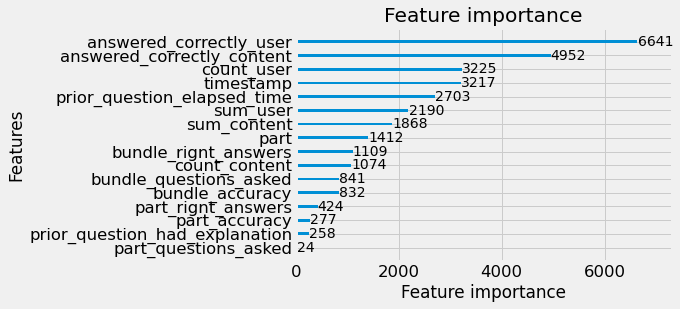

In [35]:
lgb.plot_importance(model)
plt.show()

In [36]:
iter_test = env.iter_test()

In [37]:
for (test_df, sample_prediction_df) in iter_test:
    test_df = test_df.merge(user_df, how = 'left', on = 'user_id')
    test_df = test_df.merge(questions_df, how = 'left', left_on = 'content_id', right_on = 'question_id')
    test_df = test_df.merge(bundle_df, how = 'left', on = 'bundle_id')
    test_df = test_df.merge(part_df, how = 'left', on = 'part')
    
    test_df['prior_question_elapsed_time'].fillna(test_df.groupby('user_id')
                                           ['prior_question_elapsed_time'].transform('mean'),inplace=True)
    test_df['prior_question_elapsed_time'].fillna(test_df['prior_question_elapsed_time'].mean(),inplace=True)
    test_df['prior_question_had_explanation'].fillna(test_df['prior_question_had_explanation'].mode()[0],inplace=True)
    test_df.fillna(value = -1, inplace = True)
    
    test_df["prior_question_had_explanation"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])

    test_df['answered_correctly'] =  model.predict(test_df[features])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])